# Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

## Loaded the clean dataset

In [2]:
df = pd.read_csv('clean_retail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [3]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

## Built RFM Table

Defined the snapshot date

In [4]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

Calculated Recency, frequency, and Monetary

In [5]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


## Normalized the data

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


In [7]:
rfm_scaled

array([[ 2.33485829e+00, -4.24674873e-01,  8.35963391e+00],
       [-9.05199314e-01,  3.54080191e-01,  2.51046358e-01],
       [-1.75186336e-01, -3.52973410e-02, -2.85464504e-02],
       ...,
       [-8.45198247e-01, -2.94882363e-01, -2.08712435e-01],
       [-8.85198958e-01,  1.52221279e+00,  4.57171586e-03],
       [-4.95192025e-01, -1.65089852e-01, -2.40912314e-02]])

## Finding Optimal Number of Clusters (Elbow Method)


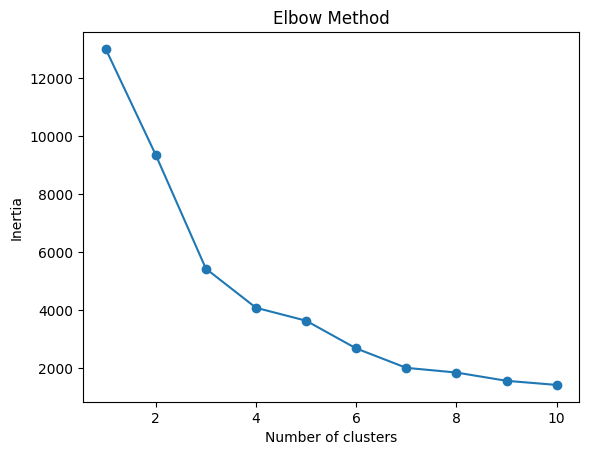

In [8]:
inertia = []
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(rfm_scaled)
    inertia.append(model.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


## Creating model with 4 clusters

In [9]:
# Created model with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)

# the model to the scaled data and assigned cluster labels
rfm['Segment'] = kmeans.fit_predict(rfm_scaled)

In [10]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Segment
0,12346.0,326,1,77183.60,0
1,12347.0,2,7,4310.00,3
2,12348.0,75,4,1797.24,3
3,12349.0,19,1,1757.55,3
4,12350.0,310,1,334.40,1


Analyzes Each segment (Group Wise average)

In [11]:
rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(1)

,Recency,Frequency,Monetary,CustomerID
Segment,,,,
0,15.7,22.0,12453.2,211
1,248.6,1.6,478.1,1062
2,7.4,82.7,127338.3,13
3,43.9,3.7,1349.7,3053


## Visualizing the lusters

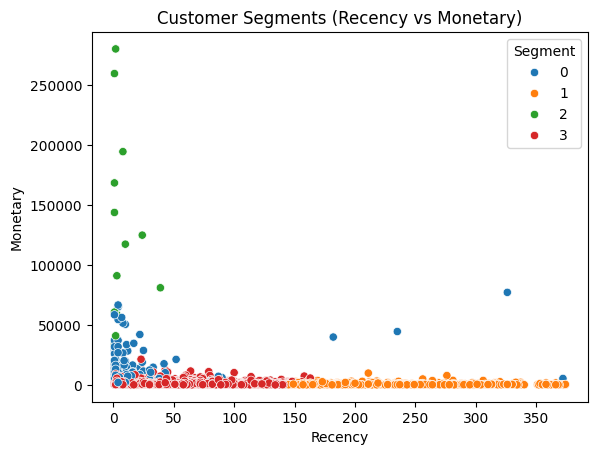

In [12]:
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Segment', palette='tab10')
plt.title('Customer Segments (Recency vs Monetary)')
plt.show()

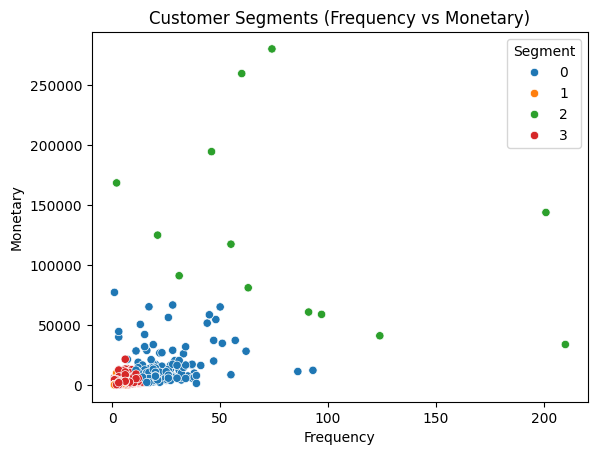

In [13]:
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Segment', palette='tab10')
plt.title('Customer Segments (Frequency vs Monetary)')
plt.show()

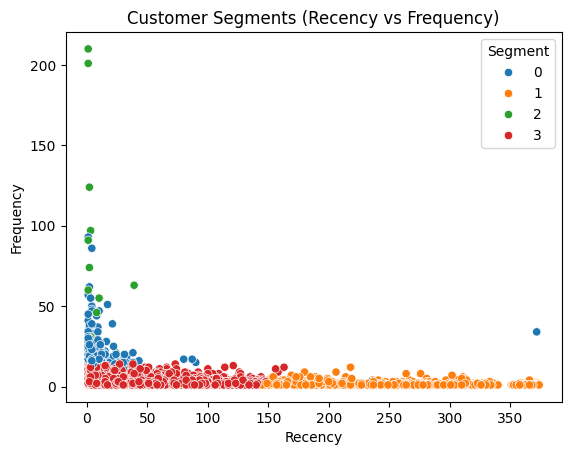

In [14]:
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Segment', palette='tab10')
plt.title('Customer Segments (Recency vs Frequency)')
plt.show()

## Saved the final RFM

In [15]:
rfm.to_csv('rfm_segmented.csv', index=False)